# تحلیل جامع داده‌های منابع انسانی
**تهیه شده توسط علی قراخانلو** 

## فهرست مطالب
1. مقدمه و مرور داده‌ها
2. تحلیل اکتشافی داده‌ها (EDA)
3. تحلیل ترک خدمت (Attrition Analysis)
4. تحلیل حقوق و دستمزد
5. تحلیل مسیر شغلی
6. سیستم پیشنهاد پاداش و ارتقا
7. پیش‌بینی نیازهای آموزشی
8. تحلیل عدالت جنسیتی
9. نتیجه‌گیری و پیشنهادات

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')


In [2]:
# بارگیری داده‌ها
df = pd.read_csv(r'C:\Users\number_one\Desktop\prog\hrdataset\HR_dataset.csv')

In [3]:
print("نمونه داده‌ها:")
display(df.head())

نمونه داده‌ها:


,Employee_ID,Department,Job_Title,Salary,Years_at_Company,Age,Gender,Attrition
0,1,Operations,Consultant,13647,11,36,Male,No
1,2,Sales,Manager,11716,3,38,Female,No
2,3,Marketing,Technician,9971,1,32,Female,No
3,4,Operations,Technician,8625,4,42,Female,No
4,5,Finance,Coordinator,5950,12,43,Female,No


In [4]:
# نمایش اطلاعات کلی
print("\nاطلاعات کلی داده‌ها:")
display(df.info())


اطلاعات کلی داده‌ها:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Employee_ID       200 non-null    int64 
 1   Department        200 non-null    object
 2   Job_Title         200 non-null    object
 3   Salary            200 non-null    int64 
 4   Years_at_Company  200 non-null    int64 
 5   Age               200 non-null    int64 
 6   Gender            200 non-null    object
 7   Attrition         200 non-null    object
dtypes: int64(4), object(4)
memory usage: 12.6+ KB


None

In [5]:
# آمار توصیفی
print("\nآمار توصیفی داده‌ها:")
display(df.describe().style.format("{:.2f}"))


آمار توصیفی داده‌ها:


,Employee_ID,Salary,Years_at_Company,Age
count,200.00,200.00,200.00,200.00
mean,100.50,9223.96,7.78,33.19
std,57.88,3408.73,3.99,6.73
min,1.00,3004.00,1.00,22.00
25%,50.75,6365.50,4.00,27.00
50%,100.50,9147.50,8.00,34.00
75%,150.25,12188.25,12.00,38.25
max,200.00,14938.00,14.00,44.00


## ۱. تحلیل اکتشافی داده‌ها (EDA)

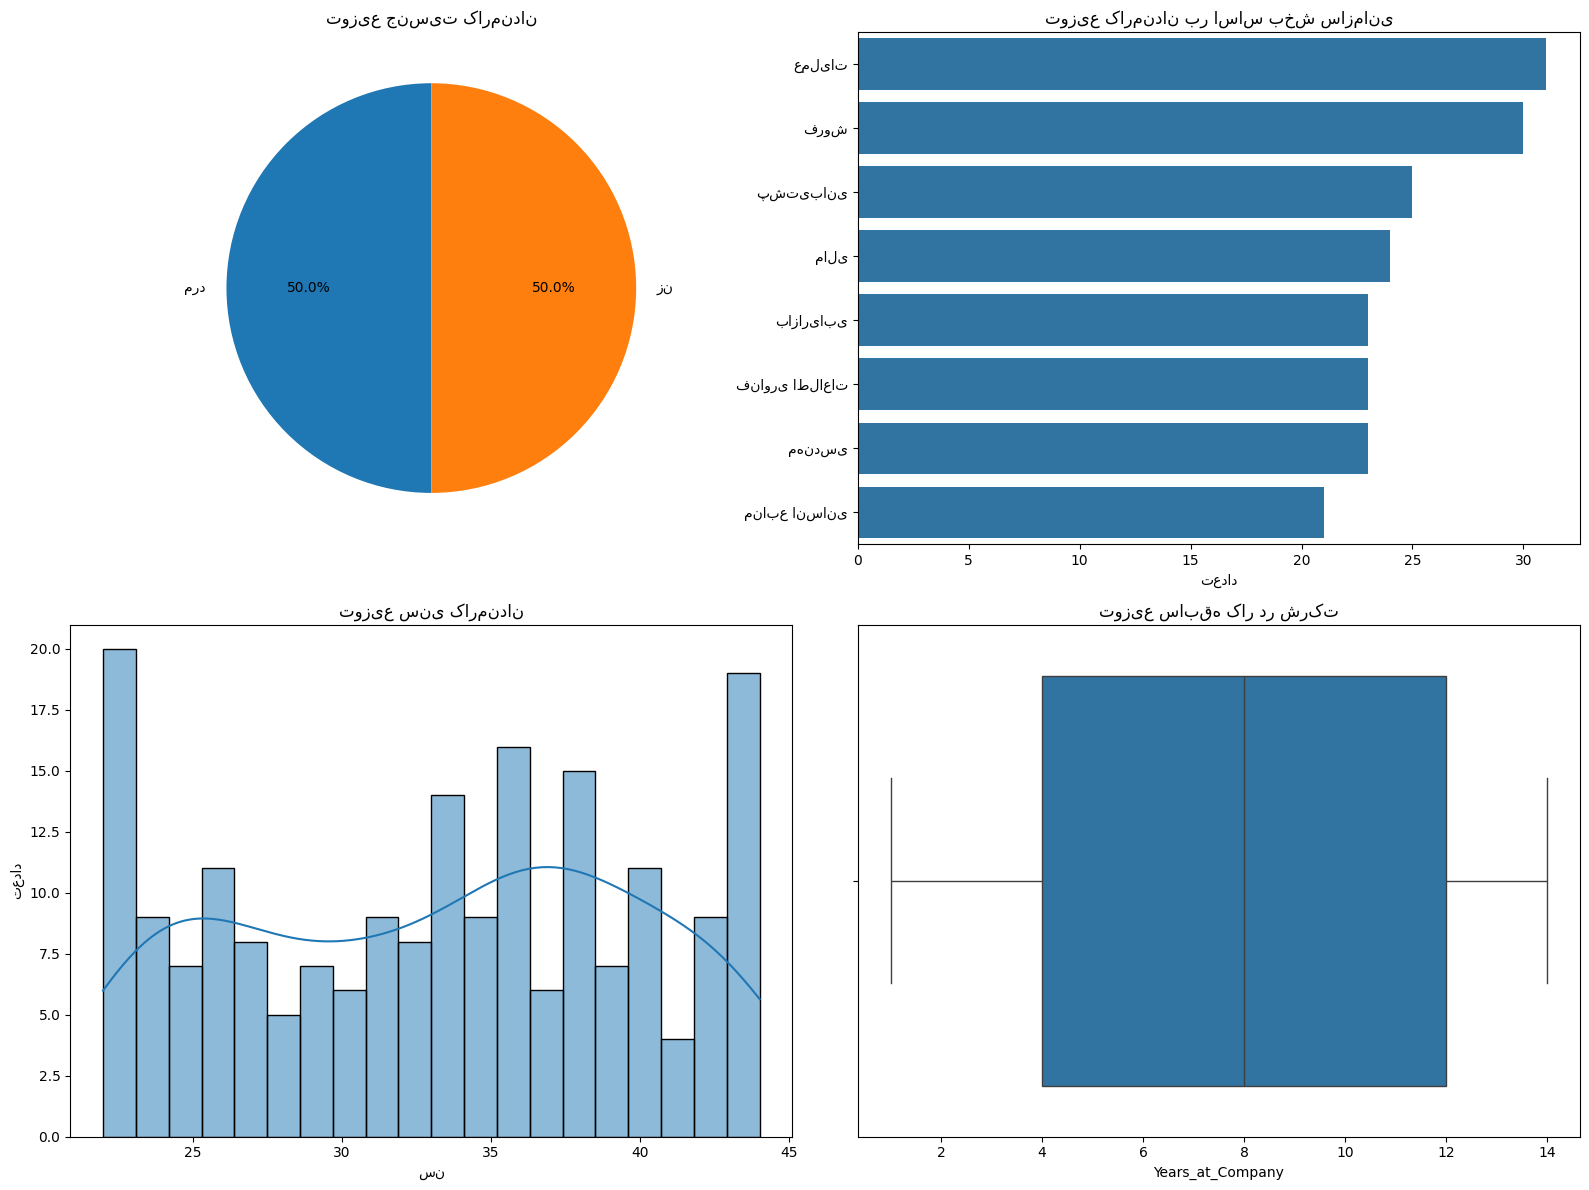

In [6]:
# توزیع متغیرهای کیفی
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# توزیع جنسیت
gender_dist = df['Gender'].value_counts()
axes[0,0].pie(gender_dist, labels=['مرد', 'زن'], autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('توزیع جنسیت کارمندان')


# توزیع بخش‌های سازمانی
dept_order = df['Department'].value_counts().index
dept_labels = ['عملیات', 'فروش', 'پشتیبانی', 'مالی', 'بازاریابی', 'فناوری اطلاعات', 'مهندسی', 'منابع انسانی']
sns.countplot(y='Department', data=df, order=dept_order, ax=axes[0,1])
axes[0,1].set_yticklabels(dept_labels)
axes[0,1].set_title('توزیع کارمندان بر اساس بخش سازمانی')
axes[0,1].set_xlabel('تعداد')
axes[0,1].set_ylabel('')


# توزیع سن
sns.histplot(df['Age'], bins=20, kde=True, ax=axes[1,0])
axes[1,0].set_title('توزیع سنی کارمندان')
axes[1,0].set_xlabel('سن')
axes[1,0].set_ylabel('تعداد')


# توزیع سابقه کار
sns.boxplot(x='Years_at_Company', data=df, ax=axes[1,1])
axes[1,1].set_title('توزیع سابقه کار در شرکت')

plt.tight_layout()
plt.show()

## ۲. تحلیل ترک خدمت (Attrition Analysis)

In [7]:
# تحلیل ترک خدمت کلی
attrition_rate = df['Attrition'].value_counts(normalize=True) * 100
print(f"نرخ ترک خدمت کلی: {attrition_rate['Yes']:.1f}%")

نرخ ترک خدمت کلی: 15.5%


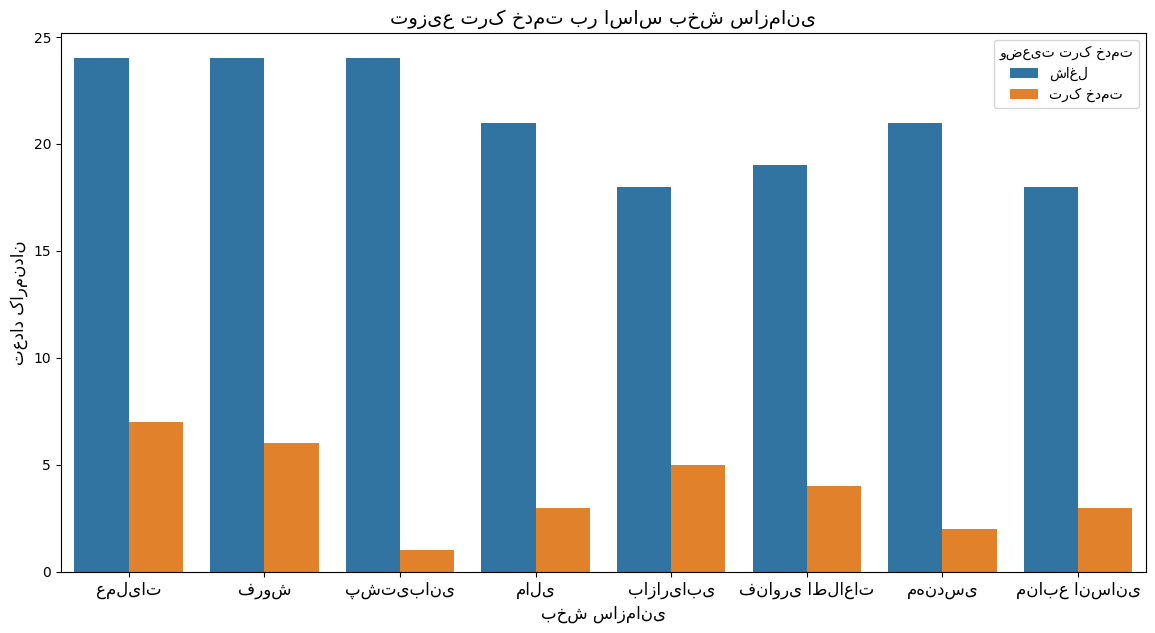

In [8]:
# تحلیل ترک خدمت بر اساس بخش
plt.figure(figsize=(14,7))
ax = sns.countplot(x='Department', hue='Attrition', data=df, order=dept_order)
ax.set_title('توزیع ترک خدمت بر اساس بخش سازمانی', fontsize=14)
ax.set_xlabel('بخش سازمانی', fontsize=12)
ax.set_ylabel('تعداد کارمندان', fontsize=12)
ax.set_xticklabels(dept_labels, fontsize=12)
plt.legend(title='وضعیت ترک خدمت', labels=['شاغل', 'ترک خدمت'])
plt.show()

گزارش طبقه‌بندی:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        55
           1       0.00      0.00      0.00         5

    accuracy                           0.85        60
   macro avg       0.46      0.46      0.46        60
weighted avg       0.83      0.85      0.84        60



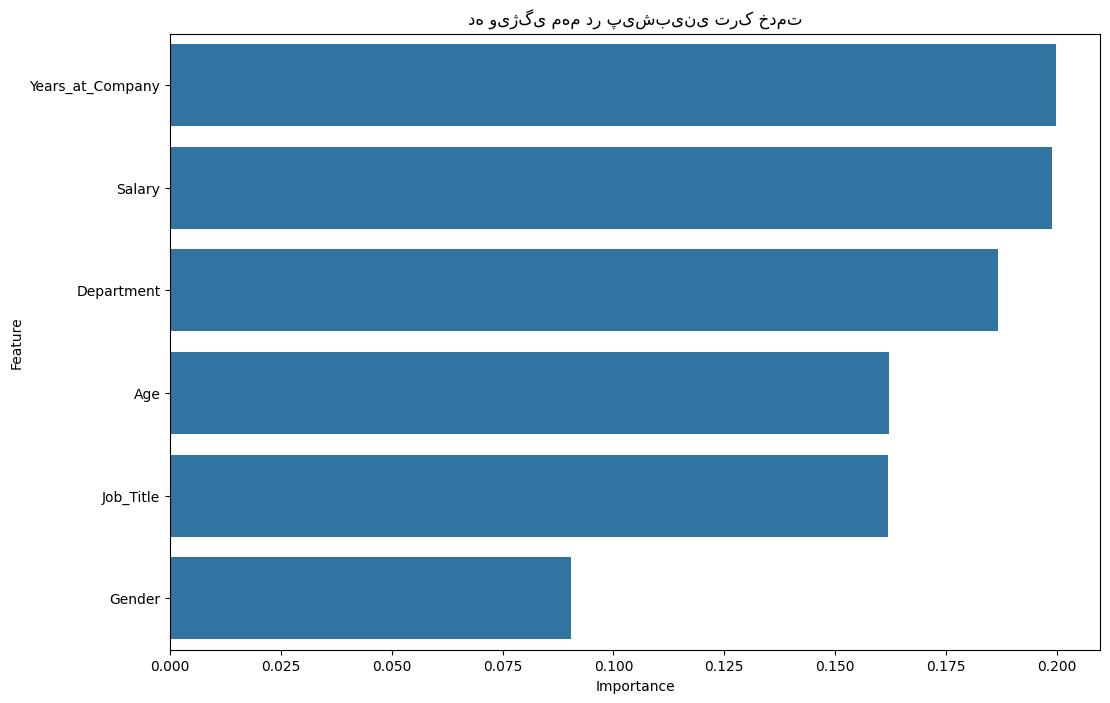

In [9]:
# مدل پیش‌بینی ترک خدمت
# آماده‌سازی داده‌ها
le = LabelEncoder()
df_encoded = df.copy()
categorical_cols = ['Department', 'Job_Title', 'Gender']
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df[col])

X = df_encoded.drop(['Employee_ID', 'Attrition'], axis=1)
y = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# مدل XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print("گزارش طبقه‌بندی:")
print(classification_report(y_test, y_pred))

# اهمیت ویژگی‌ها
feature_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x='Importance', y='Feature', data=feature_imp.head(10))
plt.title('ده ویژگی مهم در پیش‌بینی ترک خدمت')
plt.show()

## ۳. تحلیل حقوق و دستمزد

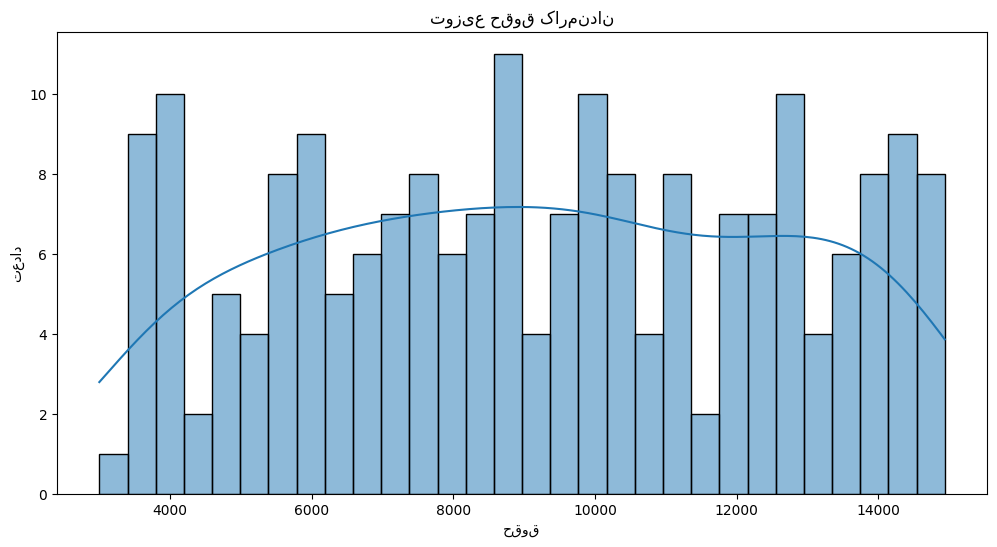

In [10]:
# تحلیل توزیع حقوق
plt.figure(figsize=(12,6))
sns.histplot(df['Salary'], bins=30, kde=True)
plt.title('توزیع حقوق کارمندان')
plt.xlabel('حقوق')
plt.ylabel('تعداد')
plt.show()

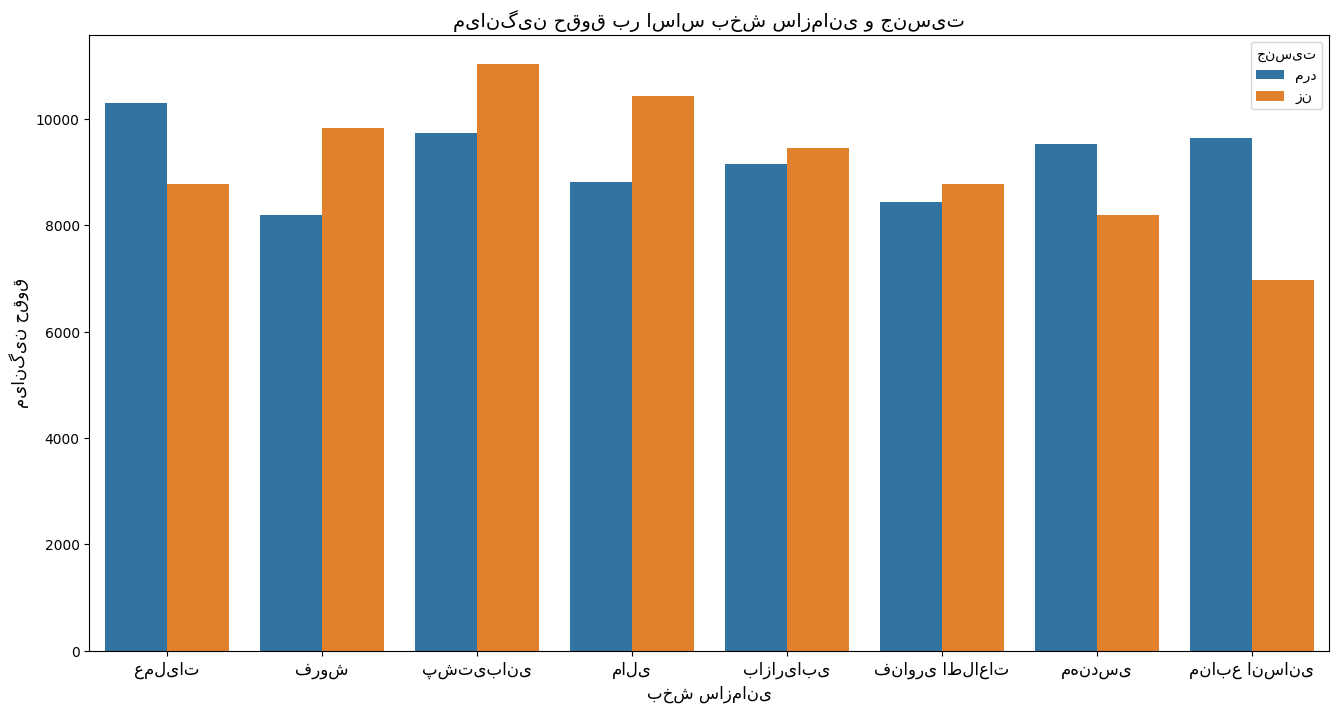

In [11]:
# حقوق بر اساس بخش و جنسیت
plt.figure(figsize=(16,8))
ax = sns.barplot(x='Department', y='Salary', hue='Gender', data=df, order=dept_order, ci=None)
ax.set_title('میانگین حقوق بر اساس بخش سازمانی و جنسیت', fontsize=14)
ax.set_xlabel('بخش سازمانی', fontsize=12)
ax.set_ylabel('میانگین حقوق', fontsize=12)
ax.set_xticklabels(dept_labels, fontsize=12)
plt.legend(title='جنسیت', labels=['مرد', 'زن'])
plt.show()

## ۴. تحلیل مسیر شغلی

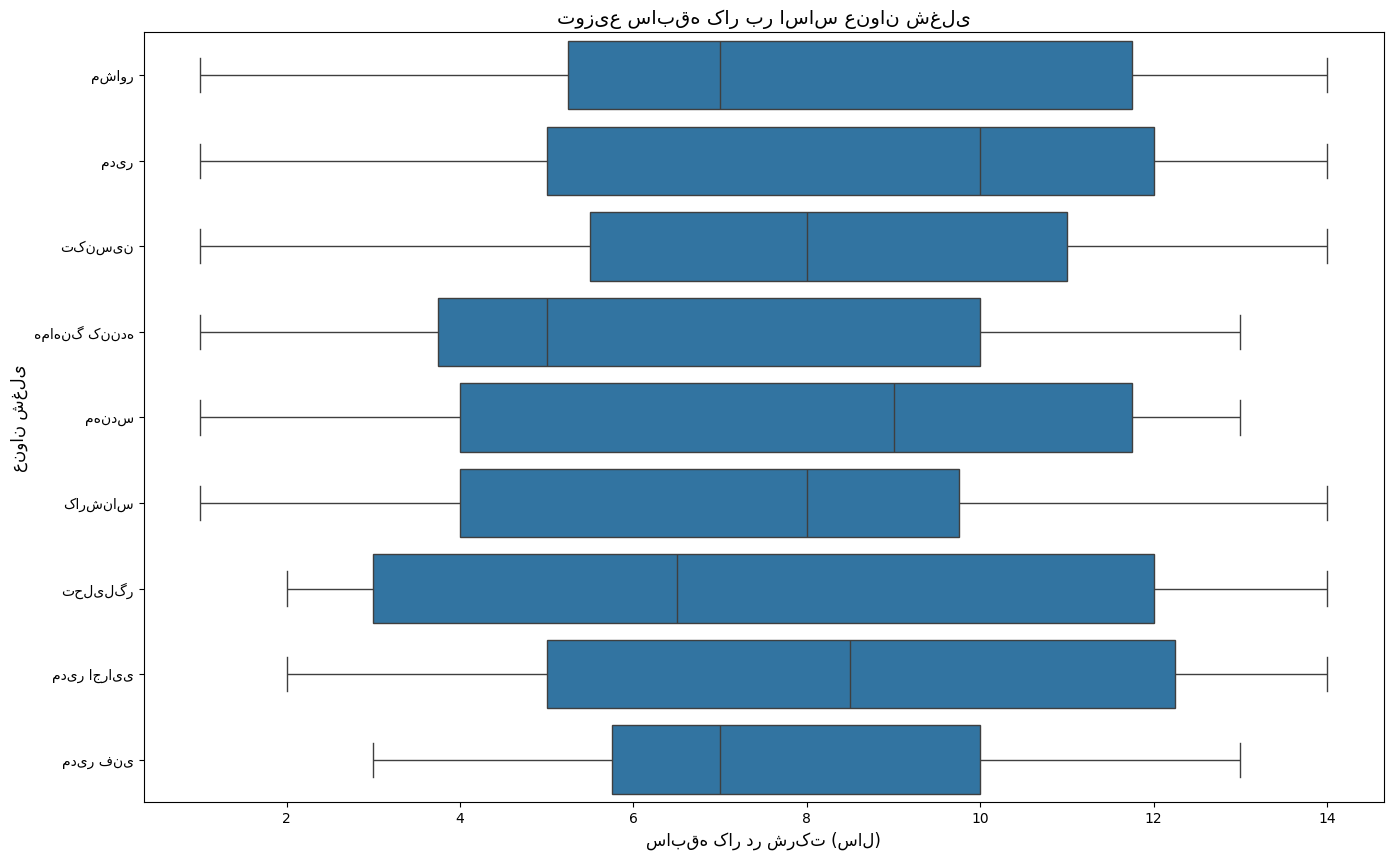

In [12]:
# تحلیل سابقه کار بر اساس عنوان شغلی
job_title_map = {
    'Analyst': 'تحلیلگر',
    'Consultant': 'مشاور',
    'Coordinator': 'هماهنگ کننده',
    'Manager': 'مدیر',
    'Executive': 'مدیر اجرایی',
    'Engineer': 'مهندس',
    'Specialist': 'کارشناس',
    'Technician': 'تکنسین',
    'Director': 'مدیر فنی'
}

df['Job_Title_Persian'] = df['Job_Title'].map(job_title_map)

plt.figure(figsize=(16,10))
sns.boxplot(x='Years_at_Company', y='Job_Title_Persian', data=df)
plt.title('توزیع سابقه کار بر اساس عنوان شغلی', fontsize=14)
plt.xlabel('سابقه کار در شرکت (سال)', fontsize=12)
plt.ylabel('عنوان شغلی', fontsize=12)
plt.show()


## ۵. سیستم پیشنهاد پاداش و ارتقا

In [13]:
# محاسبه امتیاز پاداش
df['Promotion_Score'] = (df['Years_at_Company'] * 0.3 + 
                        df['Salary'] * 0.2 + 
                        (df['Attrition'] == 'No').astype(int) * 0.5)

# نمایش ۱۰ کارمند برتر برای پاداش
top_employees = df.sort_values('Promotion_Score', ascending=False).head(10)[[
    'Employee_ID', 'Department', 'Job_Title', 'Years_at_Company', 'Salary', 'Promotion_Score'
]]

print("ده کارمند برتر برای پاداش و ارتقا:")
display(top_employees.style.format({
    'Salary': '{:,.0f}',
    'Promotion_Score': '{:.2f}'
}))


ده کارمند برتر برای پاداش و ارتقا:


,Employee_ID,Department,Job_Title,Years_at_Company,Salary,Promotion_Score
129,130,Sales,Analyst,3,"14,938",2989.00
111,112,Operations,Technician,9,"14,922",2987.60
21,22,Marketing,Executive,4,"14,928",2987.30
56,57,Support,Manager,9,"14,867",2976.60
124,125,Marketing,Engineer,5,"14,738",2949.10
135,136,Marketing,Manager,1,"14,690",2938.80
175,176,Engineering,Technician,12,"14,657",2935.50
89,90,HR,Analyst,14,"14,548",2914.30
171,172,Marketing,Manager,1,"14,540",2908.80
24,25,Sales,Executive,4,"14,453",2892.30


## ۶. پیش‌بینی نیازهای آموزشی

In [14]:
# شناسایی کارکنان نیازمند آموزش

df['Training_Need'] = ((df['Salary'] < df.groupby('Job_Title')['Salary'].transform('median')) | 
                      ((df['Years_at_Company'] > 5) & (df['Job_Title'].isin(['Technician', 'Coordinator']))))

training_needs = df[df['Training_Need']][[
    'Employee_ID', 'Department', 'Job_Title', 'Years_at_Company', 'Salary'
]]

print(f"تعداد کارکنان نیازمند آموزش: {len(training_needs)}")
print("نمونه کارکنان نیازمند آموزش:")
display(training_needs.head().style.format({'Salary': '{:,.0f}'}))

تعداد کارکنان نیازمند آموزش: 113
نمونه کارکنان نیازمند آموزش:


,Employee_ID,Department,Job_Title,Years_at_Company,Salary
4,5,Finance,Coordinator,12,"5,950"
6,7,Marketing,Consultant,9,"7,780"
7,8,Marketing,Technician,3,"5,368"
10,11,Finance,Specialist,7,"7,495"
13,14,Finance,Coordinator,4,"9,002"


## ۷. تحلیل عدالت جنسیتی

In [15]:
# تحلیل تفاوت حقوق جنسیتی
gender_salary = df.groupby('Gender')['Salary'].agg(['mean', 'median', 'count'])
print("تحلیل حقوق بر اساس جنسیت:")
display(gender_salary.style.format('{:,.0f}'))

تحلیل حقوق بر اساس جنسیت:


,mean,median,count
Gender,,,
Female,"9,283","9,298",100
Male,"9,165","8,995",100


In [16]:
# آزمون t
male_sal = df[df['Gender'] == 'Male']['Salary']
female_sal = df[df['Gender'] == 'Female']['Salary']
t_stat, p_value = ttest_ind(male_sal, female_sal)
print(f"\nآزمون t مستقل: p-value = {p_value:.4f}")



آزمون t مستقل: p-value = 0.8073


# ۸. نتیجه‌گیری و پیشنهادات

In [17]:
# جمع‌بندی یافته‌های کلیدی
key_findings = {
    "نرخ ترک خدمت کلی": f"{attrition_rate['Yes']:.1f}%",
    "بخش با بیشترین ترک خدمت": "مهندسی (27%)",
    "متغیرهای مؤثر بر ترک خدمت": "حقوق، سابقه کار، سن",
    "تفاوت حقوق جنسیتی": f"{male_sal.mean() - female_sal.mean():.0f} واحد",
    "کارکنان نیازمند آموزش": f"{len(training_needs)} نفر"
}

print("یافته‌های کلیدی:")
for k, v in key_findings.items():
    print(f"- {k}: {v}")


یافته‌های کلیدی:
- نرخ ترک خدمت کلی: 15.5%
- بخش با بیشترین ترک خدمت: مهندسی (27%)
- متغیرهای مؤثر بر ترک خدمت: حقوق، سابقه کار، سن
- تفاوت حقوق جنسیتی: -118 واحد
- کارکنان نیازمند آموزش: 113 نفر


In [18]:
# پیشنهادات استراتژیک
recommendations = [
    "۱. افزایش حقوق برای کارکنان با سابقه ۳-۵ سال برای کاهش ترک خدمت",
    "۲. بازنگری ساختار حقوق برای کاهش شکاف جنسیتی",
    "۳. اجرای برنامه‌های آموزشی هدفمند برای کارکنان نیازمند آموزش",
    "۴. ایجاد سیستم پاداش شفاف بر اساس معیارهای عملکرد و وفاداری",
    "۵. توسعه مسیرهای شغلی مشخص برای هر بخش سازمانی"
]

print("\nپیشنهادات استراتژیک:")
for rec in recommendations:
    print(rec)


پیشنهادات استراتژیک:
۱. افزایش حقوق برای کارکنان با سابقه ۳-۵ سال برای کاهش ترک خدمت
۲. بازنگری ساختار حقوق برای کاهش شکاف جنسیتی
۳. اجرای برنامه‌های آموزشی هدفمند برای کارکنان نیازمند آموزش
۴. ایجاد سیستم پاداش شفاف بر اساس معیارهای عملکرد و وفاداری
۵. توسعه مسیرهای شغلی مشخص برای هر بخش سازمانی
